### 提升方法
现在我们拥有的数据集和算法已经给出，如果用bagging方法从数据集中进行采样训练，则我们得到的模型仍然无法摆脱数据集分布固有的限制，即泛化误差的上界。如果要摆脱它，我们需要人为的改变数据分布；一种方法是为每个样本点加权，如果一个样本点在之前的学习中被错分，则下次学习中我们会更加照顾这些错分的样本。这样生成的学习器将更有可能把这些错误纠正过来。  
如何确定这个权重和每个学习器的投票重要度呢？这就是adaboost要解决的问题。
### 二分类Adaboost推导
算法的基础是基学习器，以及一个二分类数据集。我们要通过提升得到的集成模型是一个多基学习器线性加权投票委员会。$ f(x) = sign[\sum_i^M \alpha_i G_i(x)] $  
Adaboost里使用指数的损失函数套在上面的G(x)上，写为$ L(f(x),y)=exp(-yf(x)) $，我们希望在生成第m个新的基学习器时，把上面的指数损失最小化。
$$ argmin_{\alpha,G}\quad L(\alpha,G)\sum_{i=1}^{N} exp(-y_i (f_{m-1}(x_i)+\alpha G(x_i))) $$
从式子中提取出$w_{mi} = exp(-y_i(f_{m-1}(x_i)))$，它不参与优化，则上式变为$argmin_{\alpha,G}\quad \sum_{i=1}^{N} w_{mi} exp(-y_i\alpha G(x_i)) $。因为G是分类器，输出是1或-1，上式又可以进一步简化。
$$\sum_{i=1}^{N} w_{mi} exp(-y_i\alpha G(x_i)) = \sum_{y_i=G(x_i)}w_{mi} exp(-\alpha)+\sum_{y_i \neq G(x_i)}w_{mi} exp(\alpha)$$
对这个东西求个常微分等于0就得到我们需要的，现在生成的第m个学习器的权重。
$$ \frac{dL} {d\alpha}=I(y\neq G)exp(\alpha)-I(y = G)exp(-\alpha) = 0 $$
$$ \alpha = \frac{1}{2}log\frac{1-e_m}{e_m} $$
其中em是模型的错误率。到这里我们解出了单步的alpha取值，它能让我们加入这个新的基学习器G后，loss最小化。  
为了让模型学到更多，我们调整样本的权重分布。让本次被错分的样本乘以系数$exp(2\alpha) $来修正新的模型，这个系数也是推导得到的。我们把loss中G(x)的一项做泰勒展开，再做一个期望最大化就能得到。不过因为这步操作的意义比较明显，我们就不敲公式了。

### 算法
1、初始化样本权值分布，一般初始化为均匀分布。  
2、迭代M次:  
$\qquad$每次在当前的权重确定的数据分布D上生成一个基学习器。  
$\qquad$计算误差率e，赋值系数$\alpha = \frac{1}{2}log\frac{1-e_m}{e_m}$，为单个基学习器的权重。  
$\qquad$调整样本分布，$w_i \leftarrow w_i exp(-(1\ if\ y=G(x)\ else\ -1)\alpha) $  
$\qquad$归一化样本分布  
3、输出最终模型$ f(x) = sign[\sum_i^M \alpha_i G_i(x)] $

### 实战
Adaboost最著名的子产物是非常强大的梯度上升树GBDT和Xgboost。梯度上升树使用残差逼近的思想，提升地训练多个回归树CART组成强学习器。Xgboost在今天的深度学习时代依然扮演者重要角色。  
我们实作就不做Xgboost了，我们做一个西瓜书上的例子，使用决策树桩作为基学习器，训练非线性决策平面的强学习器。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import datasets

In [2]:
dataset = pd.read_csv("watermelon.csv", encoding = "gb18030")

y=dataset['好瓜']
X=dataset.drop('好瓜',axis=1)
X=X.drop('编号',axis=1)
# 转numpy
X ,y = X.values,y.values
n,m = X.shape

In [3]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=labelencoder.fit_transform(y)

In [4]:
X = X[:,[6,7]]

In [5]:
y = 2*y-1

**模型与训练**  
我们使用X的后两个维度连续特征训练决策树桩，因此我们需要先设计能在连续特征上运行的学习器。因为决策树桩对样本进行简单的二分类，而且本例子里样本平衡，所以直接用加权的准确率分数来评估如何划分即可。

In [6]:
from math import log
from collections import Counter

class stump:
    def __init__(self):
        '''
        只进行单次简单划分，划分维度是clue
        划分中值是mid，小于mid的类别为type
        '''
        self.clue = None
        self.mid = None
        self.type = None
        
    def fit(self, X, y, weights):
        '''
        遍历所有维度的所有中值点即可
        计算信息熵时要考虑权重的影响
        '''
        n,m = X.shape
        best_score = -float("inf")
        
        for d in range(m):
            scale = X[:,d].copy()
            scale.sort()
            for i in range(n-1):
                mid = 0.5*(scale[i]+scale[i+1])
                
                y_les = y[np.where(X[:,d]<=mid)]
                y_lag = y[np.where(X[:,d]>mid)]
                type_ = np.sign(y_les.sum()+random.random())
                y_pred = type_*((X[:,d]<=mid).astype(np.int)*2-1)
                score = weights[y==y_pred].sum()-weights[y!=y_pred].sum()
                
                if score>best_score:
                    best_score = score
                    self.clue = d
                    self.mid = mid
                    self.type = type_
        
    def predict(self,X):
        return self.type*((X[:,self.clue]<=self.mid).astype(np.int)*2-1)

In [7]:
model = stump()
weights = np.ones(len(X))/len(X)
model.fit(X,y,weights)

In [8]:
accuracy_score(model.predict(X),y)

0.8235294117647058

In [9]:
class MixtureStump:
    def __init__(self):
        self.models = []
        self.alphas = []
        
    def fit(self,X,y,M=10):
        n = len(X)
        weights = np.ones(n)
        weights /= weights.sum() # 初始化样本权重
        self.models.clear()
        self.alphas.clear()

        for m in range(M):
            model = stump()
            model.fit(X,y,weights)
            self.models.append(model)
            y_pred = model.predict(X)
            e = 1-accuracy_score(y_pred,y)
            if e>0.5:
                break
            alpha = np.log((1-e)/e)
            self.alphas.append(alpha)
            C = np.ones(n)
            C[y_pred==y] *= np.exp(-alpha)
            C[y_pred!=y] *= np.exp(alpha)
            weights *= C
            
    def predict(self,X):
        y_pred = sum(model.predict(X) for model in self.models)
        return np.sign(y_pred+random.random()*0.001)

In [10]:
def decision_plain(model, low1, upp1, low2, upp2):
    x_axis = np.linspace(low1,upp1,100)
    y_axis = np.linspace(low2,upp2,100)
    xx, yy = np.meshgrid(x_axis, y_axis)
    Z = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            Z[i][j] = model.predict(np.array([[xx[i][j],yy[i][j]]]))
    plt.figure(figsize=(8,6), dpi=80)
    colors = ['aquamarine','palegoldenrod']
    plt.contourf(xx, yy, Z, cmap=matplotlib.colors.ListedColormap(colors))

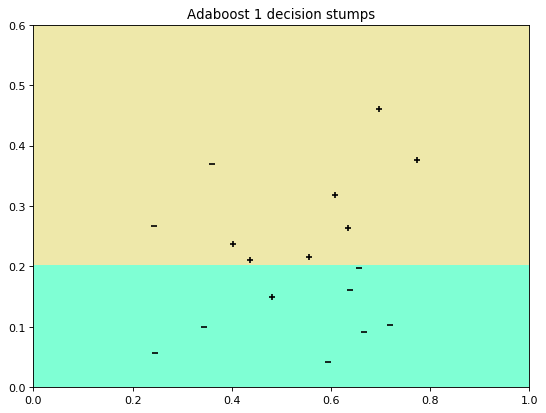

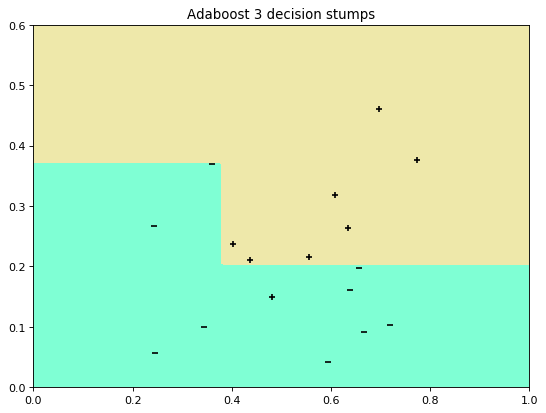

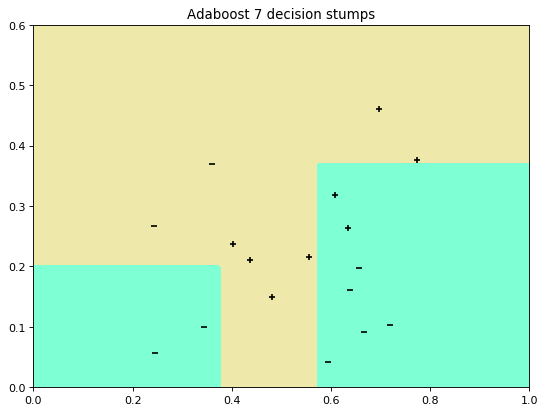

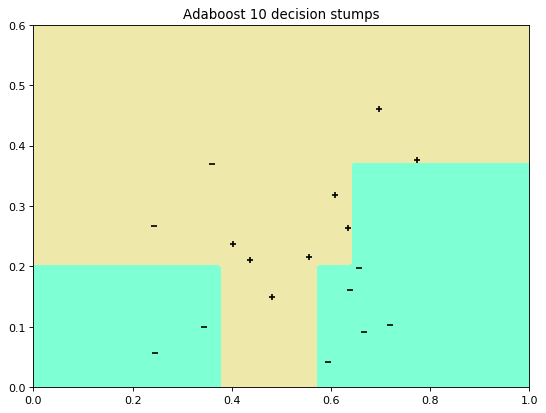

In [11]:
for num in (1,3,7,10):

    mix_model = MixtureStump()
    mix_model.fit(X,y,num)
    
    decision_plain(mix_model,0,1,0,0.6)
    plt.title("Adaboost %d decision stumps"%num)
    plt.scatter(X[y==1,0],X[y==1,1],c= 'black',marker='+')
    plt.scatter(X[y!=1,0],X[y!=1,1],c= 'black',marker='_')

### 混合专家
从上面的例子我们可以看见adaboost是怎样通过加权来提升模型性能，但是adaboost仍然有一些局限性。从上面的图中我们发现，一些原本可以正确分类的样本，在adaboost的发展过程中逐渐变得没法正确划分。这其实是有些"因小失大"的嫌疑，adaboost有时会把某些样本看得太重要而没法兼顾大局。一种很好的想法是使用"局部性"来限制模型，每个模型有自己掌管的数据区域，这个想法是通过混合带有门函数，而不是只带常数权重的基学习器实现的。  
$$ p(t|x) = \sum_{k=1}^K \pi_k(x)p_k(t|x) $$
其中pi是门函数，每个分量密度，也就是一个基学习器判别器。这样就可以对输入空间的不同区域进行建模，门函数可以是硬性的，也可以是柔和的。门函数的权重和区域由参数控制，而且需要满足概率的归一化条件，所以参数一般用EM算法调节(你可能会发现，GMM也是一种无监督的混合专家模型)。混合专家模型在某些特殊的问题上，会有着比adaboost还要更好的表现。